# Predicción de Rotación de Personal (HR Turnover Prediction)

Este notebook analiza datos de empleados para predecir el riesgo de rotación utilizando un modelo de Random Forest. El análisis incluye:
- Carga de datos desde SQL Server
- Preprocesamiento de datos
- Entrenamiento del modelo
- Evaluación de resultados
- Almacenamiento de predicciones

## 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el análisis.

In [4]:
import pandas as pd
import pymssql
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import datetime
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import numpy as np
import os

# Configuración de logging
logging.basicConfig(level=logging.INFO)

## 2. Conexión a Base de Datos y Consulta

Configuramos la conexión a SQL Server y ejecutamos la consulta para obtener los datos de empleados.

In [5]:
# Configuración de SQL Server
SQL_SERVER = "172.28.192.1:50121\\SQLEXPRESS"
SQL_DB = "HR_Analytics"
SQL_USER = "sa"
SQL_PASSWORD = "123456"

# Conectar a SQL Server usando pymssql
server_name = SQL_SERVER.split('\\')[0]  # Separar el nombre del servidor de la instancia
conn = pymssql.connect(
    server=server_name,
    user=SQL_USER,
    password=SQL_PASSWORD,
    database=SQL_DB
)

query = """
SELECT w.employee_id, w.department, w.salary, w.hire_date, w.performance_score, w.age, w.shift_type,
       AVG(k.hours_worked) as avg_hours_worked, 
       AVG(k.overtime_hours) as avg_overtime_hours, 
       AVG(s.satisfaction_score) as avg_satisfaction_score,
       CASE WHEN w.status = 'Terminated' THEN 1 ELSE 0 END AS turnover
FROM Workday_Employees w
LEFT JOIN Kronos_TimeEntries k ON w.employee_id = k.employee_id
LEFT JOIN Employee_Surveys s ON w.employee_id = s.employee_id
GROUP BY w.employee_id, w.department, w.salary, w.hire_date, w.status, w.performance_score, w.age, w.shift_type
"""

df = pd.read_sql(query, conn)
print(f"Datos cargados: {len(df)} registros")
df.head(10)

C:\Users\joey_\AppData\Local\Temp\ipykernel_12468\4147967895.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Datos cargados: 1000 registros


,employee_id,department,salary,hire_date,performance_score,age,shift_type,avg_hours_worked,avg_overtime_hours,avg_satisfaction_score,turnover
0,1589,Inventory,87621.29,2024-05-16,3,28,Morning,5.513151,0.329299,4.0,0
1,1921,Sales,32188.14,2018-04-20,8,22,Morning,5.720965,0.440511,3.0,0
2,1234,HR,147639.50,2023-02-09,9,52,Morning,5.803977,0.299517,5.0,0
3,1566,Marketing,55860.19,2017-01-15,2,38,Morning,5.754375,0.432670,5.0,0
4,1898,Marketing,76122.54,2015-12-17,10,34,Night,5.792869,0.365653,4.0,0
5,1042,Sales,75314.39,2017-01-15,7,33,Afternoon,5.883295,0.476931,3.0,0
6,1211,Finance,115030.79,2015-09-14,9,48,Morning,5.763693,0.330085,4.0,0
7,1374,HR,89284.89,2015-06-23,6,39,Morning,5.593267,0.357954,4.0,0
8,1543,IT,101307.16,2022-04-09,10,34,Afternoon,5.651420,0.434147,5.0,0
9,1875,HR,142437.91,2024-11-09,4,53,Afternoon,5.740223,0.275223,4.0,0


In [6]:
### QUALITY REPORT (PRE CLEANING)

def create_data_quality_report(df):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df)
    
    for column in df.columns:
        # Count missing values
        missing_count = df[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            zero_count = (df[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df = quality_df.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df

try:
    # Verify if df exists and is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise NameError("df is not a valid DataFrame")
    
    # Create the quality report
    quality_report = create_data_quality_report(df)

    selected_columns = df.columns.tolist()
    Q_Report = quality_report[quality_report['Column_Name'].isin(selected_columns)]
except NameError:
    print("Error: Asegúrese que la celda anterior se haya ejecutado.")
    print("El DataFrame debería ser creado en el SQL query.")

Q_Report

,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
7,avg_hours_worked,float64,1000,144,14.4,0,0.0,0,0.0,837
8,avg_overtime_hours,float64,1000,144,14.4,0,0.0,1,0.1,828
9,avg_satisfaction_score,float64,1000,139,13.9,0,0.0,0,0.0,5
0,employee_id,int64,1000,0,0.0,0,0.0,0,0.0,1000
1,department,object,1000,0,0.0,0,0.0,0,0.0,6
2,salary,float64,1000,0,0.0,0,0.0,0,0.0,1000
3,hire_date,object,1000,0,0.0,0,0.0,0,0.0,878
4,performance_score,int64,1000,0,0.0,0,0.0,0,0.0,10
5,age,int64,1000,0,0.0,0,0.0,0,0.0,43
6,shift_type,object,1000,0,0.0,0,0.0,0,0.0,3


## 3. Preprocesamiento de Datos

Preparamos los datos para el entrenamiento del modelo:
- Calculamos la antigüedad (tenure)
- Codificamos variables categóricas
- Tratamos valores faltantes

In [7]:
# Calcular antigüedad
df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['hire_date'])).dt.days / 365

# Manejo específico de avg_overtime_hours
df['avg_overtime_hours'] = df['avg_overtime_hours'].fillna(0)

# Manejo condicional de avg_hours_worked
df.loc[(df['avg_hours_worked'].isna()) & (df['tenure'] > 1/365), 'avg_hours_worked'] = 8
df.loc[(df['avg_hours_worked'].isna()) & (df['tenure'] <= 1), 'avg_hours_worked'] = 0

# Imputación de avg_satisfaction_score usando XGBoost
def impute_satisfaction_scores(df):
    # Separar datos para entrenamiento (registros con satisfaction_score)
    train_mask = ~df['avg_satisfaction_score'].isna()
    features = ['tenure', 'avg_hours_worked', 'avg_overtime_hours', 'salary', 'performance_score', 'age']
    
    X_train = df[train_mask][features]
    y_train = df[train_mask]['avg_satisfaction_score']
    
    # Preparar datos para predicción
    X_predict = df[~train_mask][features]
    
    # Crear y entrenar modelo XGBoost para imputación
    imputer = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
    
    # Entrenar modelo
    imputer.fit(X_train, y_train)
    
    # Evaluar precisión del modelo
    train_predictions = imputer.predict(X_train)
    mse = mean_squared_error(y_train, train_predictions)
    r2 = r2_score(y_train, train_predictions)
    
    print("\nMétricas del modelo de imputación:")
    print(f"Error cuadrático medio (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Realizar predicciones para valores faltantes
    predictions = imputer.predict(X_predict)
    
    # Asignar predicciones a los valores faltantes
    df.loc[~train_mask, 'avg_satisfaction_score'] = np.round(predictions, decimals=0)
    
    return df

# Aplicar imputación
df = impute_satisfaction_scores(df)

# Codificar variables categóricas
df = pd.get_dummies(df, columns=['department'], drop_first=True)

print("\nEstadísticas descriptivas después del preprocesamiento:")
print(df.describe())

# Verificar valores faltantes restantes
missing_values = df.isnull().sum()
print("\nValores faltantes restantes:")
print(missing_values[missing_values > 0])


Métricas del modelo de imputación:
Error cuadrático medio (MSE): 0.1107
R² Score: 0.8596

Estadísticas descriptivas después del preprocesamiento:
       employee_id         salary  performance_score         age  \
count  1000.000000    1000.000000        1000.000000  1000.00000   
mean   1500.500000   80706.325190           5.265000    36.65300   
std     288.819436   33400.493144           2.863385    10.11914   
min    1001.000000   30986.120000           1.000000    18.00000   
25%    1250.750000   52257.700000           3.000000    30.00000   
50%    1500.500000   75267.500000           5.000000    35.00000   
75%    1750.250000  103818.045000           8.000000    43.00000   
max    2000.000000  167334.960000          10.000000    60.00000   

       avg_hours_worked  avg_overtime_hours  avg_satisfaction_score  \
count       1000.000000         1000.000000             1000.000000   
mean           6.031527            0.305230                3.668000   
std            0.815387    

In [8]:
### QUALITY REPORT (POST CLEANING)

def create_data_quality_report(df):
    # Initialize dictionary to store quality metrics
    quality_report = {
        'Column_Name': [],
        'Data_Type': [],
        'Total_Rows': [],
        'Missing_Values': [],
        'Missing_Percentage': [],
        'Blank_Values': [],
        'Blank_Percentage': [],
        'Zero_Values': [],
        'Zero_Percentage': [],
        'Unique_Values': []
    }
    
    total_rows = len(df)
    
    for column in df.columns:
        # Count missing values
        missing_count = df[column].isna().sum()
        
        # Count blank values (empty strings)
        blank_count = df[column].astype(str).str.strip().eq('').sum()
        
        # Count zero values for numeric columns
        if pd.api.types.is_numeric_dtype(df[column]):
            zero_count = (df[column] == 0).sum()
        else:
            zero_count = 0
            
        # Count unique values
        unique_count = df[column].nunique()
        
        # Add to report
        quality_report['Column_Name'].append(column)
        quality_report['Data_Type'].append(str(df[column].dtype))
        quality_report['Total_Rows'].append(total_rows)
        quality_report['Missing_Values'].append(missing_count)
        quality_report['Missing_Percentage'].append(round(missing_count/total_rows * 100, 2))
        quality_report['Blank_Values'].append(blank_count)
        quality_report['Blank_Percentage'].append(round(blank_count/total_rows * 100, 2))
        quality_report['Zero_Values'].append(zero_count)
        quality_report['Zero_Percentage'].append(round(zero_count/total_rows * 100, 2))
        quality_report['Unique_Values'].append(unique_count)
    
    # Create DataFrame from the quality report
    quality_df = pd.DataFrame(quality_report)
    
    # Sort by missing percentage (descending)
    quality_df = quality_df.sort_values('Missing_Percentage', ascending=False)
    
    return quality_df

try:
    # Verify if df exists and is a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise NameError("df is not a valid DataFrame")
    
    # Create the quality report
    quality_report = create_data_quality_report(df)

    selected_columns = df.columns.tolist()
    Q_Report = quality_report[quality_report['Column_Name'].isin(selected_columns)]
except NameError:
    print("Error: Asegúrese que la celda anterior se haya ejecutado.")
    print("El DataFrame debería ser creado en el SQL query.")

Q_Report

,Column_Name,Data_Type,Total_Rows,Missing_Values,Missing_Percentage,Blank_Values,Blank_Percentage,Zero_Values,Zero_Percentage,Unique_Values
0,employee_id,int64,1000,0,0.0,0,0.0,0,0.0,1000
1,salary,float64,1000,0,0.0,0,0.0,0,0.0,1000
2,hire_date,object,1000,0,0.0,0,0.0,0,0.0,878
3,performance_score,int64,1000,0,0.0,0,0.0,0,0.0,10
4,age,int64,1000,0,0.0,0,0.0,0,0.0,43
5,shift_type,object,1000,0,0.0,0,0.0,0,0.0,3
6,avg_hours_worked,float64,1000,0,0.0,0,0.0,0,0.0,838
7,avg_overtime_hours,float64,1000,0,0.0,0,0.0,145,14.5,828
8,avg_satisfaction_score,float64,1000,0,0.0,0,0.0,0,0.0,5
9,turnover,int64,1000,0,0.0,0,0.0,852,85.2,2


## 4.1 Selección de Features con RFE y XGBoost


In [9]:
## 4.1 Selección de Features con RFE y XGBoost

# Preparar datos para RFE
# Identificar columnas numéricas y dummy de departamentos
numeric_features = ['salary', 'avg_hours_worked','avg_overtime_hours', 'avg_satisfaction_score', 'age', 'performance_score']
department_features = [col for col in df.columns if col.startswith('department_')]
all_features = numeric_features + department_features

print("Features totales para RFE:")
print(all_features)

X_rfe = df[all_features]
y_rfe = df['turnover']

# Escalar solo las variables numéricas
scaler = StandardScaler()
X_rfe[numeric_features] = scaler.fit_transform(X_rfe[numeric_features])

# Crear modelo XGBoost para RFE
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Aplicar RFE con más features a seleccionar para incluir departamentos
rfe_selector = RFE(
    estimator=xgb_model,
    n_features_to_select=8,  # Aumentamos el número de features a seleccionar
    step=1,
    verbose=1
)

rfe_selector.fit(X_rfe, y_rfe)

# Mostrar resultados de RFE
feature_ranking = pd.DataFrame({
    'Feature': all_features,
    'Selected': rfe_selector.support_,
    'Ranking': rfe_selector.ranking_
}).sort_values('Ranking')

print("\nResultados de la selección RFE:")
print(feature_ranking)

# Separar features seleccionados por tipo
selected_features = feature_ranking[feature_ranking['Selected']]['Feature'].tolist()
selected_numeric = [f for f in selected_features if f in numeric_features]
selected_departments = [f for f in selected_features if f in department_features]

print("\nFeatures numéricos seleccionados:")
print(selected_numeric)
print("\nDepartamentos seleccionados:")
print(selected_departments)

Features totales para RFE:
['salary', 'avg_hours_worked', 'avg_overtime_hours', 'avg_satisfaction_score', 'age', 'performance_score', 'department_HR', 'department_IT', 'department_Inventory', 'department_Marketing', 'department_Sales']
Fitting estimator with 11 features.


C:\Users\joey_\AppData\Local\Temp\ipykernel_12468\2107527849.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rfe[numeric_features] = scaler.fit_transform(X_rfe[numeric_features])


Fitting estimator with 10 features.
Fitting estimator with 9 features.

Resultados de la selección RFE:
                   Feature  Selected  Ranking
1         avg_hours_worked      True        1
2       avg_overtime_hours      True        1
3   avg_satisfaction_score      True        1
5        performance_score      True        1
7            department_IT      True        1
8     department_Inventory      True        1
9     department_Marketing      True        1
10        department_Sales      True        1
4                      age     False        2
0                   salary     False        3
6            department_HR     False        4

Features numéricos seleccionados:
['avg_hours_worked', 'avg_overtime_hours', 'avg_satisfaction_score', 'performance_score']

Departamentos seleccionados:
['department_IT', 'department_Inventory', 'department_Marketing', 'department_Sales']


## 5. Entrenamiento del Modelo

Entrenamos el modelo usando los features seleccionados por RFE y datos escalados.

Iniciando búsqueda de mejores hiperparámetros...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\joey_\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Mejores parámetros encontrados:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


c:\Users\joey_\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Reporte de clasificación detallado (umbral por defecto = 0.5):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       157
           1       0.75      0.56      0.64        43

    accuracy                           0.86       200
   macro avg       0.82      0.75      0.78       200
weighted avg       0.86      0.86      0.86       200


Matriz de Confusión (umbral por defecto):
[[149   8]
 [ 19  24]]


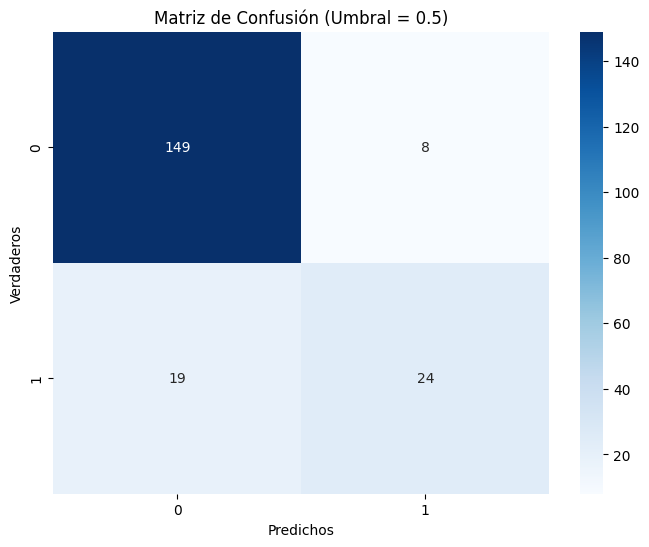

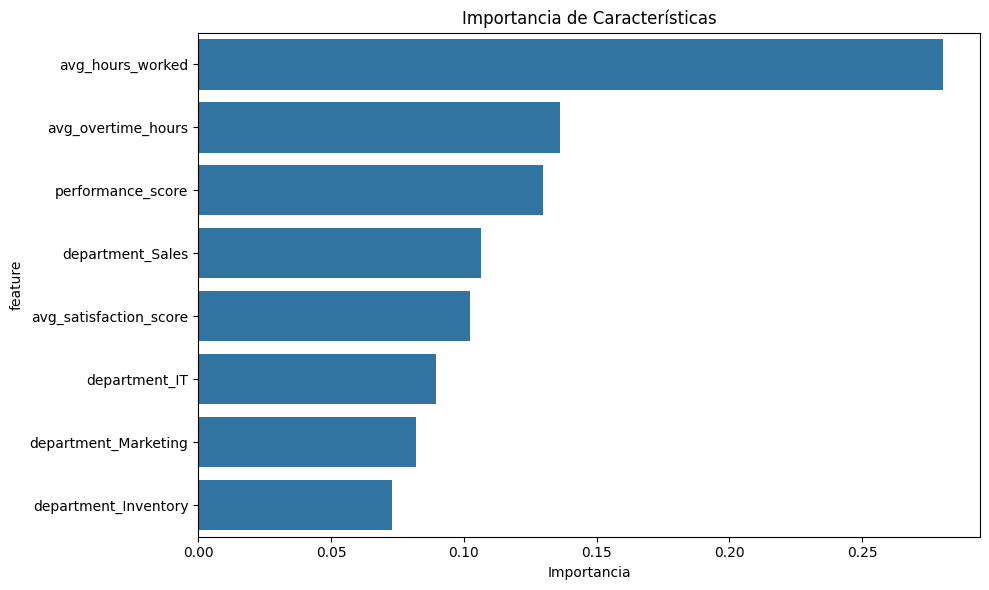


AUC-ROC: 0.9044


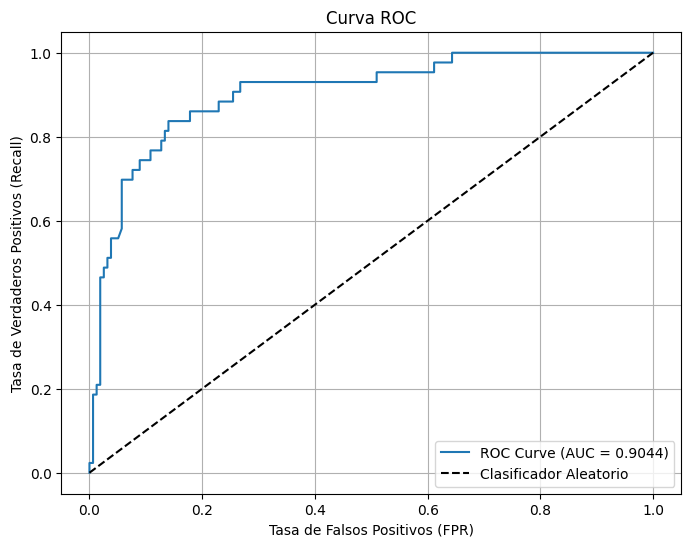


Mejor umbral de decisión: 0.05
Recall con mejor umbral: 0.8605
F1-Score con mejor umbral: 0.6852


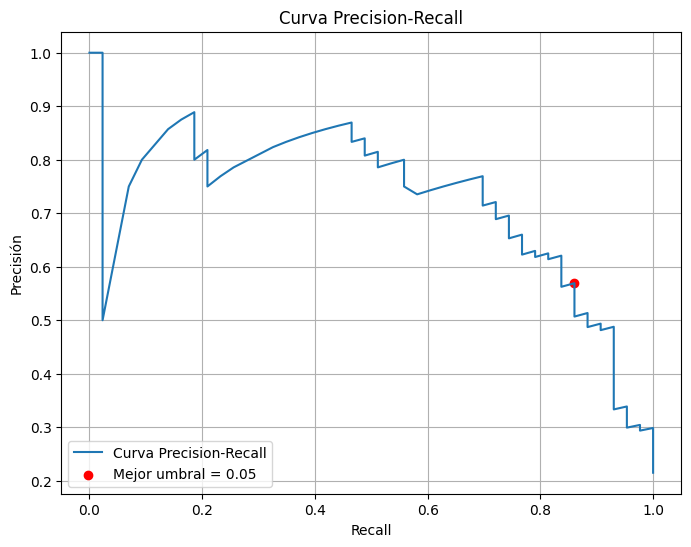


Métricas finales con umbral optimizado:
accuracy: 0.8300
precision: 0.5692
recall: 0.8605
f1_score: 0.6852

Matriz de Confusión (umbral optimizado):
[[129  28]
 [  6  37]]


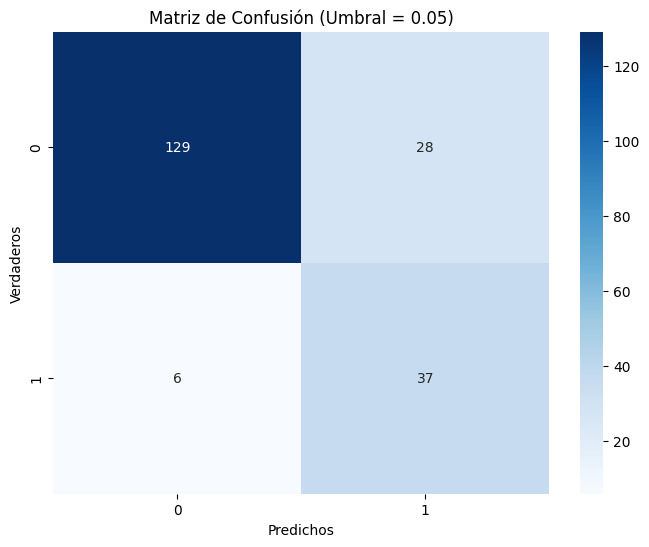

In [11]:
# Usar features seleccionados por RFE
X = df[selected_features]
y = df['turnover']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Definir parámetros para Grid Search con XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

# Crear modelo base XGBoost
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Realizar Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar modelo con Grid Search
print("Iniciando búsqueda de mejores hiperparámetros...")
grid_search.fit(X_train_balanced, y_train_balanced)

# Imprimir mejores parámetros
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Usar directamente el mejor modelo del GridSearch
model = grid_search.best_estimator_

# Entrenar el modelo final
model.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones con umbral por defecto (0.5)
y_pred = model.predict(X_test_scaled)

# Calcular y mostrar métricas detalladas con umbral por defecto
print("\nReporte de clasificación detallado (umbral por defecto = 0.5):")
print(classification_report(y_test, y_pred))

# Mostrar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión (umbral por defecto):")
print(conf_matrix)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (Umbral = 0.5)')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

# Mostrar importancia de características
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# Calcular probabilidades
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcular AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC: {auc_score:.4f}")

# Visualizar curva ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Ajustar umbral para maximizar F1-Score con un recall mínimo
min_recall = 0.85  # Umbral mínimo de recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Encontrar el mejor umbral
best_threshold = 0.5
best_f1 = 0
best_recall = 0

for i, threshold in enumerate(thresholds):
    if recalls[i] >= min_recall:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred_threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_recall = recalls[i]

print(f"\nMejor umbral de decisión: {best_threshold:.2f}")
print(f"Recall con mejor umbral: {best_recall:.4f}")
print(f"F1-Score con mejor umbral: {best_f1:.4f}")

# Visualizar curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label='Curva Precision-Recall')
plt.scatter(best_recall, precisions[np.where(thresholds == best_threshold)[0]], color='red', label=f'Mejor umbral = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Actualizar predicciones con el mejor umbral
final_predictions = (y_pred_proba >= best_threshold).astype(int)

# Calcular métricas finales
metrics = {
    'accuracy': accuracy_score(y_test, final_predictions),
    'precision': precision_score(y_test, final_predictions, zero_division=0),
    'recall': recall_score(y_test, final_predictions, zero_division=0),
    'f1_score': f1_score(y_test, final_predictions, zero_division=0)
}

print("\nMétricas finales con umbral optimizado:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Mostrar matriz de confusión con umbral optimizado
conf_matrix_opt = confusion_matrix(y_test, final_predictions)
print("\nMatriz de Confusión (umbral optimizado):")
print(conf_matrix_opt)

# Visualizar matriz de confusión con umbral optimizado
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_opt, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión (Umbral = {best_threshold:.2f})')
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

## 6. Guardar Modelo y Métricas

Guardamos el modelo entrenado y almacenamos las métricas en la base de datos.

In [12]:
# Calcular AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)

# Función para clasificar el modelo
def classify_model(recall, f1_score, auc):
    if recall > 0.85 and f1_score > 0.7 and auc > 0.8:
        return 'Bueno'
    elif (recall >= 0.7 and f1_score >= 0.5 and auc >= 0.6):
        return 'Aceptable'
    else:
        return 'Pobre'

# Determinar la calidad del modelo
model_quality = classify_model(metrics['recall'], metrics['f1_score'], auc_score)

# Crear directorio si no existe
os.makedirs('Modelos Entrenados', exist_ok=True)

# Guardar modelo
model_path = 'Modelos Entrenados/turnover_model.pkl'
joblib.dump(model, model_path)
print(f"Modelo guardado en: {model_path}")

# Guardar métricas en SQL Server
cursor = conn.cursor()
cursor.execute(
    """
    INSERT INTO ML_Model_Accuracy (model_name, run_date, accuracy, precision, recall, f1_score, AUC, quality)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """,
    ('Turnover_Prediction', datetime.datetime.now(), metrics['accuracy'],
     metrics['precision'], metrics['recall'], metrics['f1_score'], auc_score, model_quality)
)
conn.commit()
print(f"Métricas guardadas en la base de datos: Recall={metrics['recall']:.4f}, F1-Score={metrics['f1_score']:.4f}, AUC={auc_score:.4f}, Quality={model_quality}")

Modelo guardado en: Modelos Entrenados/turnover_model.pkl
Métricas guardadas en la base de datos: Recall=0.8605, F1-Score=0.6852, AUC=0.9044, Quality=Aceptable


## 7. Guardar Predicciones

Generamos y guardamos las probabilidades de rotación para todos los empleados.

In [13]:
# Calcular probabilidades y predicciones de rotación
X_scaled = scaler.transform(X)  # Escalar datos antes de predecir
df['turnover_probability'] = model.predict_proba(X_scaled)[:, 1]
df['predicted_turnover'] = (df['turnover_probability'] >= best_threshold).astype(int)

# Guardar predicciones en la base de datos
cursor = conn.cursor()
for _, row in df.iterrows():
    # Primero eliminar registros existentes
    cursor.execute(
        "DELETE FROM Turnover_Predictions WHERE employee_id = %s",
        (row['employee_id'],)
    )
    
    # Luego insertar el nuevo registro
    cursor.execute(
        """
        INSERT INTO Turnover_Predictions 
        (employee_id, prediction_date, turnover_probability, predicted_turnover)
        VALUES (%s, %s, %s, %s)
        """,
        (row['employee_id'], datetime.datetime.now(), row['turnover_probability'], row['predicted_turnover'])
    )

conn.commit() 


## 8. Cerrar conexión

Cerrando conexión con el backend.

In [14]:
conn.commit()
print("Predicciones guardadas exitosamente")

# Mostrar las 10 predicciones más altas
print("\nTop 10 empleados con mayor riesgo de rotación:")
high_risk = df[['employee_id', 'turnover_probability', 'predicted_turnover']].sort_values('turnover_probability', ascending=False).head(10)
print(high_risk)

# Mostrar distribución de predicciones
print("\nDistribución de predicciones de rotación:")
print(df['predicted_turnover'].value_counts(normalize=True).round(3) * 100, "%")

# Cerrar conexión
conn.close()
print("\nConexión a la base de datos cerrada")

Predicciones guardadas exitosamente

Top 10 empleados con mayor riesgo de rotación:
     employee_id  turnover_probability  predicted_turnover
570         1805              0.988269                   1
206         1014              0.988269                   1
986         1076              0.987981                   1
133         1658              0.983505                   1
135         1466              0.978642                   1
742         1774              0.977142                   1
467         1504              0.977142                   1
518         1988              0.976425                   1
48          1832              0.973197                   1
599         1911              0.972431                   1

Distribución de predicciones de rotación:
predicted_turnover
0    70.1
1    29.9
Name: proportion, dtype: float64 %

Conexión a la base de datos cerrada


In [15]:
df.head(25)

,employee_id,salary,hire_date,performance_score,age,shift_type,avg_hours_worked,avg_overtime_hours,avg_satisfaction_score,turnover,tenure,department_HR,department_IT,department_Inventory,department_Marketing,department_Sales,turnover_probability,predicted_turnover
0,1589,87621.29,2024-05-16,3,28,Morning,5.513151,0.329299,4.0,0,1.027397,False,False,True,False,False,0.022119,0
1,1921,32188.14,2018-04-20,8,22,Morning,5.720965,0.440511,3.0,0,7.104110,False,False,False,False,True,0.005771,0
2,1234,147639.50,2023-02-09,9,52,Morning,5.803977,0.299517,5.0,0,2.293151,True,False,False,False,False,0.001244,0
3,1566,55860.19,2017-01-15,2,38,Morning,5.754375,0.432670,5.0,0,8.364384,False,False,False,True,False,0.005457,0
4,1898,76122.54,2015-12-17,10,34,Night,5.792869,0.365653,4.0,0,9.446575,False,False,False,True,False,0.001734,0
5,1042,75314.39,2017-01-15,7,33,Afternoon,5.883295,0.476931,3.0,0,8.364384,False,False,False,False,True,0.013657,0
6,1211,115030.79,2015-09-14,9,48,Morning,5.763693,0.330085,4.0,0,9.704110,False,False,False,False,False,0.002848,0
7,1374,89284.89,2015-06-23,6,39,Morning,5.593267,0.357954,4.0,0,9.931507,True,False,False,False,False,0.000639,0
8,1543,101307.16,2022-04-09,10,34,Afternoon,5.651420,0.434147,5.0,0,3.131507,False,True,False,False,False,0.000962,0
9,1875,142437.91,2024-11-09,4,53,Afternoon,5.740223,0.275223,4.0,0,0.542466,True,False,False,False,False,0.012851,0
